In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import optuna
from optuna.samplers import TPESampler
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from optuna.integration import CatBoostPruningCallback
import matplotlib.pyplot as plt


In [2]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

class PreprocessingTemplate:
    def __init__(self):
        pass

    def fit(self, X: pd.DataFrame, y: pd.Series):
        pass

    def transform(self, X: pd.DataFrame):
        pass

    def fit_transform(self, X: pd.DataFrame, y: pd.Series):
        pass
    
    def __repr__(self):
        return self.__class__.__name__
    
def analyze_column(input_series: pd.Series) -> str:
    if pd.api.types.is_numeric_dtype(input_series):
        return 'numerical'
    else:
        return 'categorical'

class CatBoostImputer(PreprocessingTemplate):
    def __init__(self, target_cols=[], cat_features=[], fit_params=None, fit_method='fit', verbose=False):
        super().__init__()
        self.target_cols = target_cols
        self.cat_features = cat_features
        self.fit_params = {'iterations': 500, 'task_type': 'GPU', 'devices': '0'} if fit_params is None else fit_params
        self.fit_method = fit_method
        self.verbose = verbose
        self.n_features = None
        self.feature_names = None
        self._feature_scanned = False
        self.imputers = {}
        self.cat_encoder = OrdinalEncoder()

    def _transform_dataframe(self, X: pd.DataFrame, fit: bool = False):
        if fit:
            self.n_features = X.shape[1]
            self.feature_names = X.columns.tolist()
            X = pd.DataFrame(X, columns=self.feature_names)
            if len(self.cat_features) > 0 and isinstance(self.cat_features[0], int):
                self.cat_features = [self.feature_names[i] for i in self.cat_features]
        else:
            assert X.shape[1] == self.n_features, "Input shape does not match fit shape"
            X = pd.DataFrame(X, columns=self.feature_names)
        return X.copy()

    def _scan_features(self, X: pd.DataFrame):
        self.col_dict = {}
        self.target_columns = []
        self.categorical_columns = []

        for col in X.columns:
            col_arr = X[col]
            col_type = analyze_column(col_arr)
            if col in self.cat_features:  # override
                col_type = 'categorical'
            self.col_dict[col] = {'col_type': col_type, 'null_mask': col_arr.isnull()}
            if col_type == 'categorical':
                self.categorical_columns.append(col)
            if self.col_dict[col]['null_mask'].sum() > 0 or col in self.target_cols:
                self.target_columns.append(col)
        self._feature_scanned = True

    def _fit_catboost(self, X, col):
        col_info = self.col_dict[col]
        null_mask = col_info['null_mask']
        params = self.fit_params.copy()

        if col_info['col_type'] == 'categorical':
            model = CatBoostClassifier(**params)
        else:
            model = CatBoostRegressor(**params)
        
        x_train = X.loc[~null_mask].drop(col, axis=1)
        y_train = X.loc[~null_mask, col]
        model.fit(x_train, y_train, cat_features=self.cat_features if col_info['col_type'] == 'categorical' else [], verbose=self.verbose)
        
        return model
#    def _fit_catboost(self, X, col):
#        col_info = self.col_dict[col]
#        null_mask = col_info['null_mask']
#
#        # Eğitim ve test setlerini hazırlama
#        x_train = X.loc[~null_mask].drop(col, axis=1)
#        y_train = X.loc[~null_mask, col]
#
#        # Model parametrelerini ayarlama
#        if col_info['col_type'] == 'categorical' or col_info['col_type'] == "object":
#            model_params = {
#                'iterations': 5000,
#                'task_type': 'GPU',
#                'devices': '0:1',
#                'auto_class_weights': 'SqrtBalanced',
#                'verbose': self.verbose
#            }
#            # Kategorik değişken çok sınıflı ise ek parametreler
#            if col_info.get('num_class', 2) > 2:
#                model_params.update({
#                    'loss_function': 'MultiClass',
#                    'eval_metric': 'TotalF1',
#                    'custom_metric': ['F1']
#                })
#            model = CatBoostClassifier(**model_params)
#        else:  # Numerik değişkenler için
#            model = CatBoostRegressor(
#                iterations=5000,
#                task_type='GPU',
#                devices='0:1',
#                loss_function='RMSE',
#                verbose=self.verbose
#            )
#
#        # Kategorik sütunların belirlenmesi
#        cat_features_indices = [i for i, col in enumerate(x_train.columns) if col in self.cat_features]
#
#        # Modeli eğitme
#        model.fit(x_train, y_train, cat_features=cat_features_indices)
#
#        return model
    
    def fit(self, X, y=None):
        X = self._transform_dataframe(X, fit=True)
        self._scan_features(X)
        if self.categorical_columns:
            X[self.categorical_columns] = self.cat_encoder.fit_transform(X[self.categorical_columns])

        if self.verbose:
            pbar = tqdm(self.target_columns)
        else:
            pbar = self.target_columns

        for col in pbar:
            if self.verbose:
                if isinstance(pbar, tqdm):
                    pbar.set_description(f"Imputing {col}")
            self.imputers[col] = self._fit_catboost(X, col)

    def transform(self, X):
        assert self._feature_scanned, "Imputer has not been fitted yet"
        X = self._transform_dataframe(X, fit=False)
        if self.categorical_columns:
            X[self.categorical_columns] = self.cat_encoder.transform(X[self.categorical_columns])

        for col in self.target_columns:
            model = self.imputers[col]
            null_mask = X[col].isnull()
            if null_mask.sum() > 0:
                x_test = X.loc[null_mask].drop(col, axis=1)
                X.loc[null_mask, col] = model.predict(x_test)

        if self.categorical_columns:
            X[self.categorical_columns] = self.cat_encoder.inverse_transform(X[self.categorical_columns])
        return X
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


/tmp/ipykernel_55511/3934710992.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("train.csv")
/tmp/ipykernel_55511/3934710992.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv("test.csv")


In [4]:
train_data.head(20)

,MUSTERI_ID,LABEL,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,...,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG
0,61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34b...,UA,HAZIRAN,2,505,Öğretmen,105,1,34,NaN,...,0,0,0,0,0,0,0,0,0,9
1,8cd400d3897e5ff130e8e942ee1906d17531a8253d26a4...,UA,HAZIRAN,2,889,Emekli (Sosyal Güvenlik Kurumu Bilinmiyor),102,1,20,NaN,...,0,0,0,0,0,0,0,0,0,11
2,6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad...,HU19,HAZIRAN,2,578,Muhasebe,104,1,6,Yetkin,...,0,1,0,0,0,0,0,0,0,66
3,fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e...,UA,MAYIS,2,648,Diğer,106,1,34,NaN,...,0,0,0,0,0,0,0,0,0,111
4,aae8411e2c335e94922290314abe1fcc81044e8071e1c8...,UA,EYLUL,2,487,İşçi,103,1,77,NaN,...,0,0,0,0,0,0,0,0,0,90
5,89c8f825774b2cd43583a1cac8d3fcb06c94bedd47464a...,UA,MAYIS,1,468,Serbest Meslek,102,1,34,NaN,...,0,0,0,0,0,0,0,0,0,72
6,39142bd276bb368ca3834e6abc5f680bda1a4b94da75f2...,UA,HAZIRAN,2,223,Öğrenci,105,1,48,NaN,...,0,0,0,0,0,0,0,0,0,3
7,20e4006651b151e18068b8a9c9233bf5e61c06a98b3db7...,HU07,HAZIRAN,2,579,Diğer,105,1,34,NaN,...,0,0,0,0,0,0,0,0,0,108
8,2e61f5f693bb8361b142d79e365abd71525acff40b8261...,UA,HAZIRAN,1,436,İşçi,105,1,2,NaN,...,0,0,0,0,0,0,0,0,0,8
9,dd2d9f88a107406fe2921c427250c0d8c9546fea45eea8...,UA,HAZIRAN,1,192,NaN,106,1,6,NaN,...,0,0,0,0,0,0,0,0,0,14


In [5]:
test_data.head(30)

,MUSTERI_ID,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,SORU_YATIRIM_KARAKTERI_RG,...,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG
0,15b29e51dff893ac19bcbc96c96d1cda0307b4e0edafcd...,KASIM,2,467,Öğretmen,103,1,1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,100
1,7532c2d4751858dd8e7eb3f26c61af568fd3b2a6aa2f32...,KASIM,1,658,Öğretmen,106,1,54.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,111
2,47498c1c6161aea484b0eed7997846919ca9287684aee4...,KASIM,1,634,Serbest Meslek,106,1,48.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,127
3,48fe7f96c7e04326f1669b4ae5bdc5ae030da6b8c26498...,KASIM,2,638,NaN,106,1,67.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,178
4,26dbe514ebfdb7b664760c07f94d0bf0b297528cd5a358...,KASIM,1,80,Öğrenci,106,1,34.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,3
5,d854474ee38b3e83b2c6b5ccdecbfde6747581342b3544...,KASIM,2,548,İşçi,105,1,19.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,11
6,40c6dcd93e6149216a41e9bb8ab0e08fd6ad3b7bb9ab10...,KASIM,2,29,Öğrenci,106,1,34.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,8
7,3260e11b653464a0de6d85d84de2d8f063ba563e5ef317...,KASIM,2,490,Ev Hanımı,105,1,2.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,19
8,c24c505678faaa835da5e9d7f6586b1aac5afa53d0248c...,KASIM,2,132,NaN,106,1,34.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
9,b86bb1515d4bf51f47752629fb602b95bad6a167297c25...,KASIM,1,290,İşçi,103,1,31.0,NaN,NaN,...,0,0,0,0,0,0,0,1,0,12


In [6]:
urun_ozellik = pd.read_excel("Urun Ozellikleri.xlsx")
urun_ozellik

,Ürün,Branş,Grup/Ferdi,Kredili/Kredisiz,Taşınan Teminat,Biriktiren/ Koruma,Sigortas Süresi,Yenileme Fonksiyonu,Yaş Gereksinimi
0,BU01,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
1,BU02,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,18-25
2,BU03,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
3,BU04,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
4,BU05,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
5,BU06,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
6,BU07,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
7,BU08,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
8,BU09,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
9,BU10,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN


In [7]:
bolge_id = pd.read_excel("SehirlerBolgeler.xlsx")
bolge_id

,Id,SehirAd,Nufus,BolgeId,BolgeAd
0,1,Adana,2201670,1,Akdeniz Bölgesi
1,2,Adıyaman,610484,4,Güneydoğu Anadolu Bölgesi
2,3,Afyonkarahisar,714523,3,Ege Bölgesi
3,4,Ağrı,542255,2,Doğu Anadolu Bölgesi
4,5,Amasya,326351,6,Karadeniz Bölgesi
...,...,...,...,...,...
76,77,Yalova,241665,7,Marmara Bölgesi
77,78,Karabük,242347,6,Karadeniz Bölgesi
78,79,Kilis,130825,4,Güneydoğu Anadolu Bölgesi
79,80,Osmaniye,522175,1,Akdeniz Bölgesi


In [8]:
def il_mapper(data, lookup_table):
    id_to_sehirad = dict(zip(lookup_table['Id'], lookup_table['BolgeId']))

    # Map the SehirAd values to the BolgeId column in the data DataFrame
    data['IL'] = data['IL'].map(id_to_sehirad).fillna(0).astype(int)



In [9]:
def preprocess_age(data):
    data["PP_YAS"] = np.where(data["PP_YAS"] < 216, 0, data["PP_YAS"])
    data["PP_YAS"] = np.where((data["PP_YAS"] >= 216) & (data["PP_YAS"] < 600), 1, data["PP_YAS"])
    data["PP_YAS"] = np.where((data["PP_YAS"] >= 600) & (data["PP_YAS"] < 720), 2, data["PP_YAS"])
    data["PP_YAS"] = np.where((data["PP_YAS"] >= 720) & (data["PP_YAS"] < 780), 3, data["PP_YAS"])
    data["PP_YAS"] = np.where((data["PP_YAS"] >= 780) & (data["PP_YAS"] < 828), 4, data["PP_YAS"])
    data["PP_YAS"] = np.where((data["PP_YAS"] >= 828), 5, data["PP_YAS"])

In [10]:
def vade_odeme_tutar(df):
    # Set negative values to 0
    for i in range(12):
        df[f'VADE_TUTAR_{i}'] = np.where(df[f'VADE_TUTAR_{i}'] < 0, np.nan, df[f'VADE_TUTAR_{i}'])
        df[f'ODEME_TUTAR_{i}'] = np.where(df[f'ODEME_TUTAR_{i}'] < 0, np.nan, df[f'ODEME_TUTAR_{i}'])

    # Total Vade Tutar and Total Odeme Tutar
    df['TOTAL_VADE_TUTAR'] = df[[f'VADE_TUTAR_{i}' for i in range(12)]].sum(axis=1)
    df['TOTAL_ODEME_TUTAR'] = df[[f'ODEME_TUTAR_{i}' for i in range(12)]].sum(axis=1)
    
    # Average Vade Tutar
    df['AVG_VADE_TUTAR'] = round(df[[f'VADE_TUTAR_{i}' for i in range(12)]].mean(axis=1), 2)
    
    # Vade to Odeme Ratio
    df['VADE_ODEME_RATIO'] = np.where(
        df['TOTAL_ODEME_TUTAR'] == 0, np.nan,
        round(df['TOTAL_VADE_TUTAR'] / df['TOTAL_ODEME_TUTAR'], 2)
    )
    
    # Payment Consistency
    df['ODEME_TUTAR_STD'] = round(df[[f'ODEME_TUTAR_{i}' for i in range(12)]].std(axis=1), 2)
    
    return df


In [11]:
def katki_miktari(df):
    for column in ['SON_AY_KATKI_ADET', 'SON_CEYREK_KATKI_ADET', 'SON_SENE_KATKI_ADET']:
        df[column] = np.where(df[column] < 0, np.nan, df[column])

    df['AVG_KATKI_MIKTARI_SON_AY'] = np.where(
        df['SON_AY_KATKI_ADET'] == 0, np.nan,
        round(df['SON_AY_KATKI_MIKTARI'] / df['SON_AY_KATKI_ADET'], 2)
    )
    df['AVG_KATKI_MIKTARI_SON_CEYREK'] = np.where(
        df['SON_CEYREK_KATKI_ADET'] == 0, np.nan,
        round(df['SON_CEYREK_KATKI_MIKTARI'] / df['SON_CEYREK_KATKI_ADET'], 2)
    )
    df['AVG_KATKI_MIKTARI_SON_SENE'] = np.where(
        df['SON_SENE_KATKI_ADET'] == 0, np.nan,
        round(df['SON_SENE_KATKI_MIKTARI'] / df['SON_SENE_KATKI_ADET'], 2)
    )

    df['KATKI_MIKTARI_GROWTH_RATE_AY_CEYREK'] = np.where(
        df['SON_AY_KATKI_MIKTARI'] == 0, np.nan,
        round((df['SON_CEYREK_KATKI_MIKTARI'] - df['SON_AY_KATKI_MIKTARI']) / df['SON_AY_KATKI_MIKTARI'], 2)
    )
    df['KATKI_MIKTARI_GROWTH_RATE_CEYREK_SENE'] = np.where(
        df['SON_CEYREK_KATKI_MIKTARI'] == 0, np.nan,
        round((df['SON_SENE_KATKI_MIKTARI'] - df['SON_CEYREK_KATKI_MIKTARI']) / df['SON_CEYREK_KATKI_MIKTARI'], 2)
    )

    # df['KATKI_STABILITY'] = round(df[['SON_AY_KATKI_MIKTARI', 'SON_CEYREK_KATKI_MIKTARI', 'SON_SENE_KATKI_MIKTARI']].std(axis=1), 2)

    return df


In [12]:
def getiri_anapara(df):
    df['ANAPARA'] = np.where(df['ANAPARA'] < 0, np.nan, df['ANAPARA'])
    df['GETIRI'] = np.where(df['GETIRI'] < 0, np.nan, df['GETIRI'])

    df['ROI'] = np.where(
        df['ANAPARA'] == 0, np.nan, 
        round((df['GETIRI'] / df['ANAPARA']) * 100, 2)
    )
    # df['LOG_RETURN'] = np.where(
    #     df['ANAPARA'] == 0, 0, 
    #     round(np.log(1 + df['GETIRI'] / df['ANAPARA']), 2)
    # )
    df['ANNUALIZED_RETURN'] = np.where(
        (df['ANAPARA'] == 0) | (df['AKTIF_ILK_POLICE_RG'] == 0), 0, 
        round(((1 + df['ROI'] / 100) ** (12 / df['AKTIF_ILK_POLICE_RG'])) - 1, 2)
    )

    return df


In [13]:
preprocess_age(train_data)
preprocess_age(test_data)

In [14]:
print(len(train_data))
print(len(test_data))

len(train_data["MUSTERI_ID"].unique())


852719
195631


852719

In [15]:
train_data.columns

Index(['MUSTERI_ID', 'LABEL', 'FLAG', 'PP_CINSIYET', 'PP_YAS', 'PP_MESLEK',
       'PP_MUSTERI_SEGMENTI', 'PP_UYRUK', 'IL', 'SORU_YATIRIM_KARAKTERI_CVP',
       'SORU_YATIRIM_KARAKTERI_RG', 'SORU_MEDENI_HAL_CVP',
       'SORU_MEDENI_HAL_RG', 'SORU_EGITIM_CVP', 'SORU_EGITIM_RG',
       'SORU_GELIR_CVP', 'SORU_GELIR_RG', 'SORU_COCUK_SAYISI_CVP',
       'SORU_COCUK_SAYISI_RG', 'BES_AYRILMA_TALEP_ADET', 'ODEMEME_TALEP_ADET',
       'HAYAT_AYRILMA_TALEP_ADET', 'BILGI_TALEP_ADET', 'VADE_TUTAR_0',
       'ODEME_TUTAR_0', 'VADE_TUTAR_1', 'ODEME_TUTAR_1', 'VADE_TUTAR_2',
       'ODEME_TUTAR_2', 'VADE_TUTAR_3', 'ODEME_TUTAR_3', 'VADE_TUTAR_4',
       'ODEME_TUTAR_4', 'VADE_TUTAR_5', 'ODEME_TUTAR_5', 'VADE_TUTAR_6',
       'ODEME_TUTAR_6', 'VADE_TUTAR_7', 'ODEME_TUTAR_7', 'VADE_TUTAR_8',
       'ODEME_TUTAR_8', 'VADE_TUTAR_9', 'ODEME_TUTAR_9', 'VADE_TUTAR_10',
       'ODEME_TUTAR_10', 'VADE_TUTAR_11', 'ODEME_TUTAR_11',
       'SON_AY_KATKI_MIKTARI', 'SON_AY_KATKI_ADET', 'SON_CEYREK_KATKI_MIKTARI'

In [16]:
test_data.columns

Index(['MUSTERI_ID', 'FLAG', 'PP_CINSIYET', 'PP_YAS', 'PP_MESLEK',
       'PP_MUSTERI_SEGMENTI', 'PP_UYRUK', 'IL', 'SORU_YATIRIM_KARAKTERI_CVP',
       'SORU_YATIRIM_KARAKTERI_RG', 'SORU_MEDENI_HAL_CVP',
       'SORU_MEDENI_HAL_RG', 'SORU_EGITIM_CVP', 'SORU_EGITIM_RG',
       'SORU_GELIR_CVP', 'SORU_GELIR_RG', 'SORU_COCUK_SAYISI_CVP',
       'SORU_COCUK_SAYISI_RG', 'BES_AYRILMA_TALEP_ADET', 'ODEMEME_TALEP_ADET',
       'HAYAT_AYRILMA_TALEP_ADET', 'BILGI_TALEP_ADET', 'VADE_TUTAR_0',
       'ODEME_TUTAR_0', 'VADE_TUTAR_1', 'ODEME_TUTAR_1', 'VADE_TUTAR_2',
       'ODEME_TUTAR_2', 'VADE_TUTAR_3', 'ODEME_TUTAR_3', 'VADE_TUTAR_4',
       'ODEME_TUTAR_4', 'VADE_TUTAR_5', 'ODEME_TUTAR_5', 'VADE_TUTAR_6',
       'ODEME_TUTAR_6', 'VADE_TUTAR_7', 'ODEME_TUTAR_7', 'VADE_TUTAR_8',
       'ODEME_TUTAR_8', 'VADE_TUTAR_9', 'ODEME_TUTAR_9', 'VADE_TUTAR_10',
       'ODEME_TUTAR_10', 'VADE_TUTAR_11', 'ODEME_TUTAR_11',
       'SON_AY_KATKI_MIKTARI', 'SON_AY_KATKI_ADET', 'SON_CEYREK_KATKI_MIKTARI',
       

In [17]:
months_to_check = ['MAYIS', 'HAZIRAN','TEMMUZ','AGUSTOS','EYLUL','EKIM']
filtered_data = train_data[train_data['FLAG'].isin(months_to_check)]
columns_to_check = filtered_data.columns
nan_mask = filtered_data[columns_to_check].isnull().any(axis=1)
nan_rows = filtered_data[nan_mask]
nan_counts_per_label_and_month = nan_rows.groupby(['LABEL', 'FLAG']).size().unstack(fill_value=0)
nan_counts_per_label_and_month = nan_counts_per_label_and_month.reindex(columns=months_to_check, fill_value=0)

nan_counts_per_label_and_month

FLAG,MAYIS,HAZIRAN,TEMMUZ,AGUSTOS,EYLUL,EKIM
LABEL,,,,,,
HU06,545,647,570,503,474,438
HU07,518,757,557,626,706,564
HU11,80,73,83,38,75,90
HU12,91,124,101,116,124,120
HU14,1416,2066,1605,1863,2114,1690
HU15,52,121,68,57,53,63
HU19,79,83,103,133,232,129
UA,243507,248221,83338,81378,85365,90609


In [18]:
months_to_drop = ['MAYIS', 'HAZIRAN']
# train_data = train_data[~train_data['FLAG'].isin(months_to_drop)]
condition = (train_data['FLAG'].isin(months_to_drop)) & (train_data['LABEL'] == 'UA') & (train_data.isnull().sum(axis=1) > 8)

train_data = train_data[~condition]

In [19]:
il_mapper(train_data,bolge_id)
il_mapper(test_data, bolge_id)

vade_odeme_tutar(train_data)
vade_odeme_tutar(test_data).head(30)

katki_miktari(train_data)
katki_miktari(test_data)

getiri_anapara(train_data)
getiri_anapara(test_data)

,MUSTERI_ID,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,SORU_YATIRIM_KARAKTERI_RG,...,AVG_VADE_TUTAR,VADE_ODEME_RATIO,ODEME_TUTAR_STD,AVG_KATKI_MIKTARI_SON_AY,AVG_KATKI_MIKTARI_SON_CEYREK,AVG_KATKI_MIKTARI_SON_SENE,KATKI_MIKTARI_GROWTH_RATE_AY_CEYREK,KATKI_MIKTARI_GROWTH_RATE_CEYREK_SENE,ROI,ANNUALIZED_RETURN
0,15b29e51dff893ac19bcbc96c96d1cda0307b4e0edafcd...,KASIM,2,1,Öğretmen,103,1,1,NaN,NaN,...,555.83,NaN,0.00,NaN,NaN,NaN,NaN,NaN,269.37,0.17
1,7532c2d4751858dd8e7eb3f26c61af568fd3b2a6aa2f32...,KASIM,1,2,Öğretmen,106,1,7,NaN,NaN,...,901.00,1.0,175.16,NaN,NaN,NaN,NaN,NaN,235.65,0.14
2,47498c1c6161aea484b0eed7997846919ca9287684aee4...,KASIM,1,2,Serbest Meslek,106,1,3,NaN,NaN,...,2305.67,NaN,0.00,NaN,NaN,NaN,NaN,NaN,1028.57,0.26
3,48fe7f96c7e04326f1669b4ae5bdc5ae030da6b8c26498...,KASIM,2,2,NaN,106,1,6,NaN,NaN,...,626.33,NaN,0.00,NaN,NaN,NaN,NaN,NaN,601.36,0.14
4,26dbe514ebfdb7b664760c07f94d0bf0b297528cd5a358...,KASIM,1,0,Öğrenci,106,1,7,NaN,NaN,...,111.33,1.0,164.45,NaN,NaN,NaN,NaN,NaN,7.18,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195626,a81089c7050cfa5bdb47d519cfc616f66aa28bc5bda0b5...,ARALIK,2,1,NaN,105,1,7,NaN,NaN,...,83.50,1.0,151.06,NaN,NaN,NaN,NaN,NaN,1.79,0.24
195627,fd4362b714e47318627997b801111f34b25c243e6ae550...,KASIM,2,1,Ev Hanımı,105,1,7,NaN,NaN,...,569.83,1.0,110.16,NaN,NaN,NaN,NaN,NaN,27.95,0.34
195628,bf0aba86aa8ece82920ce0fea1d1a013d0f80f3761ad47...,ARALIK,1,1,Mühendis,105,1,7,NaN,NaN,...,79.67,1.0,186.06,NaN,NaN,NaN,NaN,NaN,1.01,0.13
195629,7cf9130d00d3393bb1a1f3b1815eb267c7546e90fc466a...,ARALIK,1,1,Profesyonel Meslek Mensupları,105,1,3,NaN,NaN,...,119.58,1.0,414.25,NaN,NaN,NaN,NaN,NaN,66.85,0.00


In [20]:
months_to_check = ['MAYIS', 'HAZIRAN','TEMMUZ','AGUSTOS','EYLUL','EKIM']
filtered_data = train_data[train_data['FLAG'].isin(months_to_check)]
columns_to_check = filtered_data.columns
nan_mask = filtered_data[columns_to_check].isnull().any(axis=1)
nan_rows = filtered_data[nan_mask]
nan_counts_per_label_and_month = nan_rows.groupby(['LABEL', 'FLAG']).size().unstack(fill_value=0)
nan_counts_per_label_and_month = nan_counts_per_label_and_month.reindex(columns=months_to_check, fill_value=0)

nan_counts_per_label_and_month

FLAG,MAYIS,HAZIRAN,TEMMUZ,AGUSTOS,EYLUL,EKIM
LABEL,,,,,,
HU06,545,647,570,503,474,438
HU07,518,757,557,626,706,564
HU11,80,73,83,38,75,90
HU12,91,124,101,116,124,120
HU14,1416,2066,1605,1863,2114,1690
HU15,52,121,68,57,53,63
HU19,79,83,103,133,232,129
UA,93782,94578,83341,81379,85365,90610


In [21]:
def count_nans(data):
    nan_counts = data.isna().sum()
    columns_with_nans = nan_counts[nan_counts > 0]
    return columns_with_nans


count_nans(train_data)

PP_MESLEK                                 39022
SORU_YATIRIM_KARAKTERI_CVP               435266
SORU_YATIRIM_KARAKTERI_RG                435266
SORU_MEDENI_HAL_CVP                         755
SORU_MEDENI_HAL_RG                          755
SORU_EGITIM_CVP                           56067
SORU_EGITIM_RG                            56067
SORU_GELIR_CVP                           127226
SORU_GELIR_RG                            127226
SORU_COCUK_SAYISI_CVP                    202112
SORU_COCUK_SAYISI_RG                     202112
SON_AY_KATKI_MIKTARI                     548374
SON_AY_KATKI_ADET                        548374
SON_CEYREK_KATKI_MIKTARI                 543991
SON_CEYREK_KATKI_ADET                    543991
SON_SENE_KATKI_MIKTARI                   535919
SON_SENE_KATKI_ADET                      535919
GETIRI                                    32404
VADE_ODEME_RATIO                         160426
AVG_KATKI_MIKTARI_SON_AY                 548374
AVG_KATKI_MIKTARI_SON_CEYREK            

In [22]:
count_nans(test_data)

PP_MESLEK                                 26439
SORU_YATIRIM_KARAKTERI_CVP               168244
SORU_YATIRIM_KARAKTERI_RG                168244
SORU_MEDENI_HAL_CVP                         316
SORU_MEDENI_HAL_RG                          316
SORU_EGITIM_CVP                           27084
SORU_EGITIM_RG                            27084
SORU_GELIR_CVP                            79699
SORU_GELIR_RG                             79699
SORU_COCUK_SAYISI_CVP                    113535
SORU_COCUK_SAYISI_RG                     113535
SON_AY_KATKI_MIKTARI                     195303
SON_AY_KATKI_ADET                        195303
SON_CEYREK_KATKI_MIKTARI                 193712
SON_CEYREK_KATKI_ADET                    193712
SON_SENE_KATKI_MIKTARI                   191885
SON_SENE_KATKI_ADET                      191885
GETIRI                                    13810
VADE_ODEME_RATIO                          46198
AVG_KATKI_MIKTARI_SON_AY                 195303
AVG_KATKI_MIKTARI_SON_CEYREK            

In [23]:
time_and_label = train_data[["FLAG","LABEL"]]
time_and_label

,FLAG,LABEL
2,HAZIRAN,HU19
3,MAYIS,UA
4,EYLUL,UA
7,HAZIRAN,HU07
11,EKIM,HU14
...,...,...
852707,EYLUL,UA
852708,EYLUL,HU14
852709,EYLUL,UA
852713,HAZIRAN,UA


In [24]:
label_counts_per_label = train_data.groupby('FLAG')['LABEL'].nunique().reset_index(name='unique_label_count')
label_counts_per_label

,FLAG,unique_label_count
0,AGUSTOS,8
1,EKIM,8
2,EYLUL,8
3,HAZIRAN,8
4,MAYIS,8
5,TEMMUZ,8


In [25]:
label_counts = train_data.groupby(['FLAG', 'LABEL']).size().reset_index(name='count')
label_counts

,FLAG,LABEL,count
0,AGUSTOS,HU06,503
1,AGUSTOS,HU07,626
2,AGUSTOS,HU11,38
3,AGUSTOS,HU12,116
4,AGUSTOS,HU14,1863
5,AGUSTOS,HU15,57
6,AGUSTOS,HU19,133
7,AGUSTOS,UA,81405
8,EKIM,HU06,438
9,EKIM,HU07,564


In [26]:
months_order = {
    'OCAK': 1, 'SUBAT': 2, 'MART': 3, 'NİSAN': 4, 'MAYIS': 5, 'HAZIRAN': 6,
    'TEMMUZ': 7, 'AGUSTOS': 8, 'EYLUL': 9, 'EKIM': 10, 'KASIM': 11, 'ARALIK': 12
}

In [27]:
pivot_label_counts = label_counts.pivot(index='FLAG', columns='LABEL', values='count').fillna(0)
pivot_label_counts["MONTH_ORDER"] = pivot_label_counts.index.map(months_order)
pivot_label_counts = pivot_label_counts.sort_values(by="MONTH_ORDER")
pivot_label_counts = pivot_label_counts.drop(columns=["MONTH_ORDER"])
pivot_label_counts

LABEL,HU06,HU07,HU11,HU12,HU14,HU15,HU19,UA
FLAG,,,,,,,,
MAYIS,545,518,80,91,1416,52,79,93880
HAZIRAN,647,757,73,124,2066,121,83,94679
TEMMUZ,571,557,83,101,1605,68,103,83372
AGUSTOS,503,626,38,116,1863,57,133,81405
EYLUL,474,706,75,124,2114,53,232,85392
EKIM,438,564,90,120,1690,64,129,90671


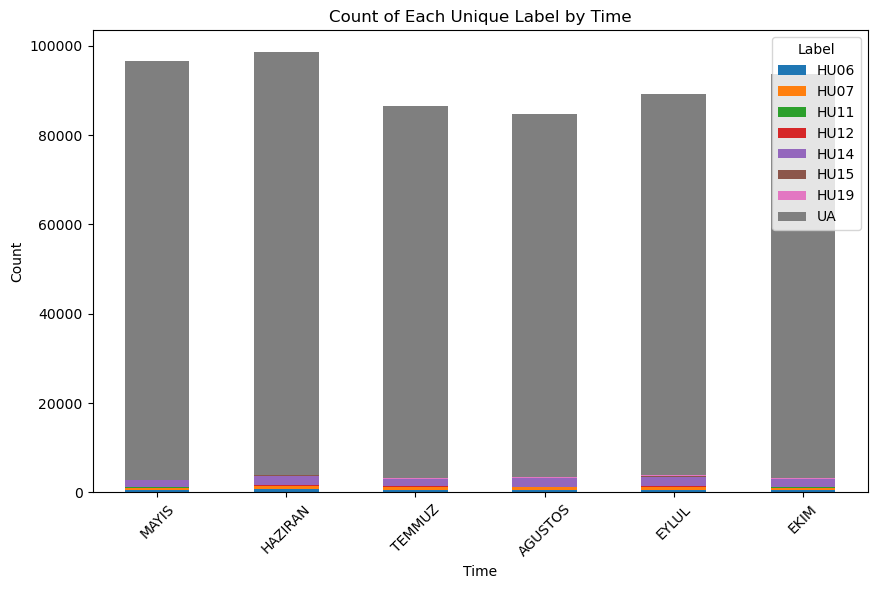

In [28]:
pivot_label_counts.plot(kind='bar', stacked=True, figsize=(10, 6))  
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Count of Each Unique Label by Time')
plt.legend(title='Label')
plt.xticks(rotation=45)  
plt.show()


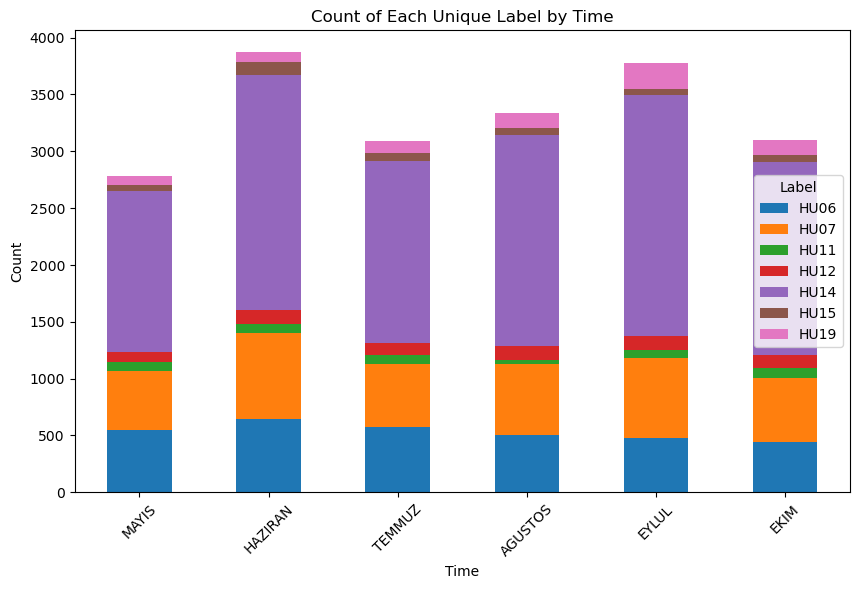

In [29]:
pivot_label_counts_without_ua = pivot_label_counts.drop(columns=["UA"])

pivot_label_counts_without_ua.plot(kind='bar', stacked=True, figsize=(10, 6))  
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Count of Each Unique Label by Time')
plt.legend(title='Label')
plt.xticks(rotation=45)  
plt.show()


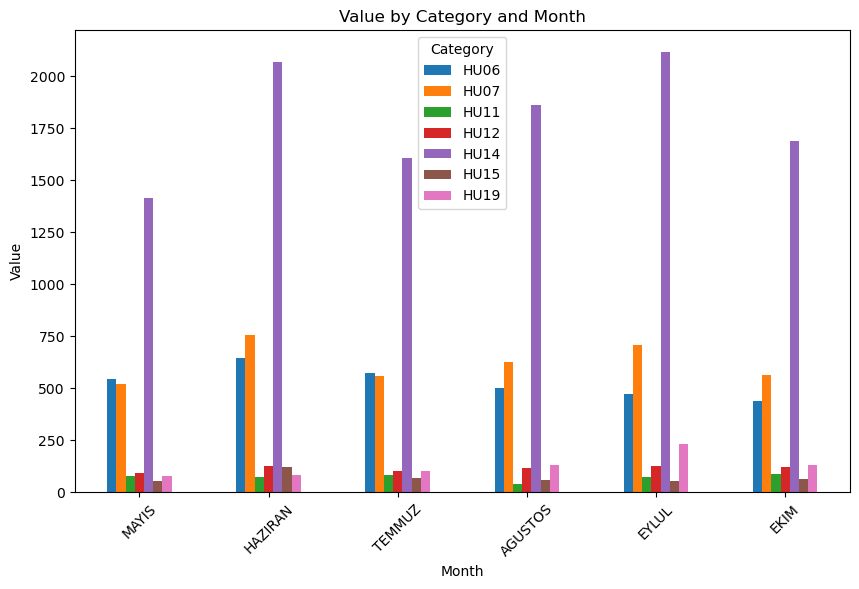

In [30]:
pivot_label_counts_without_ua.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month')  
plt.ylabel('Value')
plt.title('Value by Category and Month')
plt.xticks(rotation=45)  
plt.legend(title='Category')
plt.show()

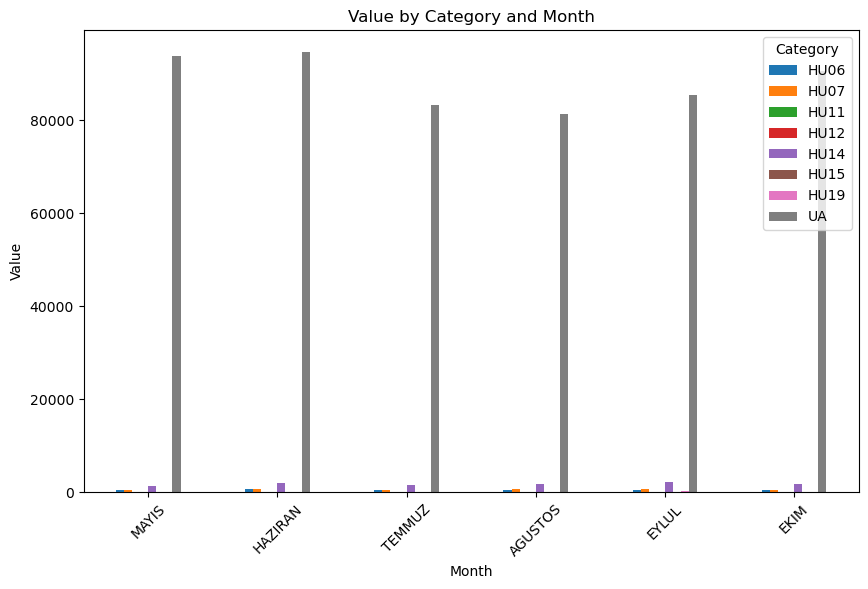

In [31]:
pivot_label_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month')  
plt.ylabel('Value')
plt.title('Value by Category and Month')
plt.xticks(rotation=45)  
plt.legend(title='Category')
plt.show()

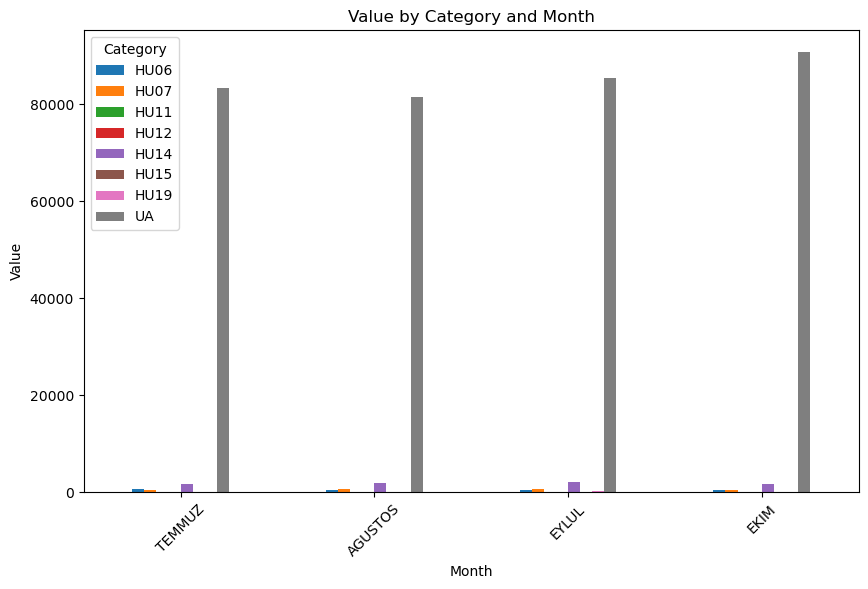

In [32]:
pivoted_label_without_two_month = pivot_label_counts.iloc[2:]

pivoted_label_without_two_month.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month')  
plt.ylabel('Value')
plt.title('Value by Category and Month')
plt.xticks(rotation=45)  
plt.legend(title='Category')
plt.show()

In [33]:
columns_to_check = [col for col in train_data.columns if col not in ['FLAG']]
nan_mask_per_row = train_data[columns_to_check].isnull().any(axis=1)
nan_counts_per_flag = train_data[nan_mask_per_row].groupby('FLAG').size()
filtered_data = train_data[nan_mask_per_row]
print(nan_counts_per_flag)
filtered_data

FLAG
AGUSTOS    84715
EKIM       93704
EYLUL      89143
HAZIRAN    98449
MAYIS      96563
TEMMUZ     86428
dtype: int64


,MUSTERI_ID,LABEL,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,...,AVG_VADE_TUTAR,VADE_ODEME_RATIO,ODEME_TUTAR_STD,AVG_KATKI_MIKTARI_SON_AY,AVG_KATKI_MIKTARI_SON_CEYREK,AVG_KATKI_MIKTARI_SON_SENE,KATKI_MIKTARI_GROWTH_RATE_AY_CEYREK,KATKI_MIKTARI_GROWTH_RATE_CEYREK_SENE,ROI,ANNUALIZED_RETURN
2,6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad...,HU19,HAZIRAN,2,1,Muhasebe,104,1,5,Yetkin,...,856.42,1.00,278.58,NaN,NaN,NaN,NaN,NaN,70.02,0.10
3,fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e...,UA,MAYIS,2,2,Diğer,106,1,7,NaN,...,395.33,NaN,0.00,NaN,NaN,NaN,NaN,NaN,279.21,0.15
4,aae8411e2c335e94922290314abe1fcc81044e8071e1c8...,UA,EYLUL,2,1,İşçi,103,1,7,NaN,...,388.67,3.39,207.59,NaN,NaN,NaN,NaN,NaN,83.53,0.08
7,20e4006651b151e18068b8a9c9233bf5e61c06a98b3db7...,HU07,HAZIRAN,2,1,Diğer,105,1,7,NaN,...,326.50,1.00,108.14,NaN,NaN,NaN,NaN,NaN,227.61,0.14
11,9327b4497439d768c9dcc33f8d41a3d0968ded2660b868...,HU14,EKIM,1,1,İşyeri Sahibi/Ortağı,103,1,5,NaN,...,390.50,1.00,91.36,NaN,NaN,NaN,NaN,NaN,26.34,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852707,e92098543d5bda159cc7f02295350406404e25a98e12fa...,UA,EYLUL,2,0,Öğrenci,106,1,1,NaN,...,27.83,1.00,96.42,NaN,NaN,NaN,NaN,NaN,1.06,0.13
852708,31a13b30a5f5fb6200989cd39be47ef13fdf100e3cb5ac...,HU14,EYLUL,1,1,Tacir ve Esnaf,102,1,5,NaN,...,583.67,1.11,224.88,NaN,NaN,NaN,NaN,NaN,114.20,0.29
852709,a3ba51ef14f964225d5b4d67f5f7ed67cfa56dc1e309b9...,UA,EYLUL,1,1,İşçi,104,1,7,NaN,...,775.50,1.00,396.26,NaN,NaN,NaN,NaN,NaN,194.21,0.12
852713,d8137ce2e4cee7d0599e9f1ab95e17478d70a47f311496...,UA,HAZIRAN,1,1,Mühendis,104,1,7,NaN,...,852.92,1.00,546.66,NaN,NaN,NaN,NaN,NaN,33.97,0.17


Data Pre-Processing

In [34]:
# Fill Non-Categorical columns with the median of their own column
def fill_with_median(data):
    non_categorical_columns = data.select_dtypes(exclude=['category', 'object']).columns
    columns_with_nans = data.columns[data.isna().any()]

    non_categorical_with_nans = [col for col in non_categorical_columns if col in columns_with_nans]
    print(non_categorical_with_nans)

    for col in non_categorical_columns:
        median_value = data[col].median()
        data[col] = data[col].fillna(median_value)

In [35]:
# fill_with_median(train_data)
# fill_with_median(test_data)

print(count_nans(test_data))
count_nans(train_data)

PP_MESLEK                                 26439
SORU_YATIRIM_KARAKTERI_CVP               168244
SORU_YATIRIM_KARAKTERI_RG                168244
SORU_MEDENI_HAL_CVP                         316
SORU_MEDENI_HAL_RG                          316
SORU_EGITIM_CVP                           27084
SORU_EGITIM_RG                            27084
SORU_GELIR_CVP                            79699
SORU_GELIR_RG                             79699
SORU_COCUK_SAYISI_CVP                    113535
SORU_COCUK_SAYISI_RG                     113535
SON_AY_KATKI_MIKTARI                     195303
SON_AY_KATKI_ADET                        195303
SON_CEYREK_KATKI_MIKTARI                 193712
SON_CEYREK_KATKI_ADET                    193712
SON_SENE_KATKI_MIKTARI                   191885
SON_SENE_KATKI_ADET                      191885
GETIRI                                    13810
VADE_ODEME_RATIO                          46198
AVG_KATKI_MIKTARI_SON_AY                 195303
AVG_KATKI_MIKTARI_SON_CEYREK            

PP_MESLEK                                 39022
SORU_YATIRIM_KARAKTERI_CVP               435266
SORU_YATIRIM_KARAKTERI_RG                435266
SORU_MEDENI_HAL_CVP                         755
SORU_MEDENI_HAL_RG                          755
SORU_EGITIM_CVP                           56067
SORU_EGITIM_RG                            56067
SORU_GELIR_CVP                           127226
SORU_GELIR_RG                            127226
SORU_COCUK_SAYISI_CVP                    202112
SORU_COCUK_SAYISI_RG                     202112
SON_AY_KATKI_MIKTARI                     548374
SON_AY_KATKI_ADET                        548374
SON_CEYREK_KATKI_MIKTARI                 543991
SON_CEYREK_KATKI_ADET                    543991
SON_SENE_KATKI_MIKTARI                   535919
SON_SENE_KATKI_ADET                      535919
GETIRI                                    32404
VADE_ODEME_RATIO                         160426
AVG_KATKI_MIKTARI_SON_AY                 548374
AVG_KATKI_MIKTARI_SON_CEYREK            

In [36]:
labels = train_data["LABEL"].value_counts()
labels

UA      529399
HU14     10754
HU07      3728
HU06      3178
HU19       759
HU12       676
HU11       439
HU15       415
Name: LABEL, dtype: int64

In [37]:
train_data["LABEL"].isna().sum()

0

In [38]:
def convert_numeric_fill_median(data):
    data["SORU_GELIR_CVP"] = pd.to_numeric(data["SORU_GELIR_CVP"], errors="coerce")
    # median_value = data["SORU_GELIR_CVP"].median()
    # data["SORU_GELIR_CVP"].fillna(median_value,inplace=True)

    # print(data["SORU_GELIR_CVP"].head(10))

In [39]:
# "SORU_GELIR_CVP" column is an object tpe column but it should be float
convert_numeric_fill_median(train_data)
convert_numeric_fill_median(test_data)

In [40]:
def get_categorical_columns(data):
    categorical_columns = data.select_dtypes(include=["category", "object"]).columns

    columns_to_remove = ["MUSTERI_ID", "LABEL"]
    categorical_columns_updated = [col for col in categorical_columns if col not in columns_to_remove]

    return categorical_columns_updated

## Kategorik değişkenler grubuna şu bize verdikleri FLAG şeklinde olan ürünleri ifade eden kolonları da dahil ediyorum

In [41]:
categorical_columns = get_categorical_columns(train_data)

In [42]:
for i in ["PP_CINSIYET","PP_YAS","PP_MUSTERI_SEGMENTI","PP_UYRUK","IL",'BU01', 'BU02', 'BU03',
       'BU04', 'BU05', 'BU06', 'BU07', 'BU08', 'BU09', 'BU10', 'BU11', 'BU12',
       'BU13', 'BU14', 'BU15', 'BU16', 'BU17', 'BU18', 'BU19', 'BU20', 'BU21',
       'BU22', 'BU23', 'BU24', 'HU01', 'HU02', 'HU03', 'HU04', 'HU05', 'HU06',
       'HU07', 'HU10', 'HU11', 'HU12', 'HU13', 'HU14', 'HU15', 'HU16', 'HU17',
       'HU18', 'HU19']:
    categorical_columns.append(i)

for column in categorical_columns:
    if column in train_data.columns:
        train_data[column] = train_data[column].astype('category')

for column in categorical_columns:
    if column in test_data.columns:
        test_data[column] = test_data[column].astype('category')

In [43]:
def calculate_class_weights(data_y):
    freq = data_y.value_counts()
    inv_freq = 1 / freq
    weights = inv_freq / inv_freq.sum()
    class_weights = {label: weight for label, weight in weights.items()}
    sorted_keys = np.sort(list(class_weights.keys()))
    print(sorted_keys)
    sorted_weights_by_keys = [class_weights[key] for key in sorted_keys]

    return sorted_weights_by_keys

In [44]:
custom_weights = np.array([0.0385, 0.0328, 0.2791, 0.1812, 0.0113, 0.2952, 0.1614, 0.0001])
scaled_weights = custom_weights / custom_weights.min()

## *Burada SORU_GELIR_CVP değişkeninde 40k üstü ve 1k altı olanların normal olmadığını ve outlier olduğunu düşündüğümden bunları NA olarak işaretliyorum. Diğer numerik değişkenlerde de outlier durumlar var. Ama bu SORU_GELIR_CVP değişken soru cevap şeklinde olduğundan kişiler sallamışta olabilirler o yüzden sadece bunun outlierlarını HANDLE edeceğim. Onu da aşağıdaki kodda bahsedeceğim.*

## *Aynı zamanda hem test setine hem de train setine uyguluyorum bu durumu*

In [45]:
def outlier_handle(df):
    indexies = df.loc[(df['SORU_GELIR_CVP'] > 40000) | (df['SORU_GELIR_CVP'] < 1000),"SORU_GELIR_CVP"].index
    df.loc[(df['SORU_GELIR_CVP'] > 70000) | (df['SORU_GELIR_CVP'] < 1000),"SORU_GELIR_CVP"] = np.nan
    return df

train_data = outlier_handle(train_data)
test_data = outlier_handle(test_data)

In [46]:
null_ratios = train_data.isnull().sum() / len(train_data)


columns_with_nulls = null_ratios[null_ratios > 0].apply(lambda x: f"{x:.7f}")

### Daha sonra burada en yukarıda tanımlı olan CatBoostImputer çağırıyorum ve umpute işleminde sadece numerik değerleri kullanıyorum. Diğer değerlerde kullanılabilirdi ben böyle tercih ettim.

In [47]:
%%time

num_cols = train_data.drop(['PP_MESLEK', 'SORU_YATIRIM_KARAKTERI_CVP', 'SORU_MEDENI_HAL_CVP','SORU_EGITIM_CVP'],axis=1).select_dtypes(include=['int64', 'float64']).columns
#selected_cols = df.drop(['MUSTERI_ID','LABEL','is_train'],axis=1).columns
print(num_cols)
imputer = CatBoostImputer(verbose=False)

train_data[num_cols] = imputer.fit_transform(train_data[num_cols])
test_data[num_cols] = imputer.fit_transform(test_data[num_cols])
#for i in num_cols:
#    df[i] = df[i].fillna(df[i].mean())

Index(['SORU_YATIRIM_KARAKTERI_RG', 'SORU_MEDENI_HAL_RG', 'SORU_EGITIM_RG',
       'SORU_GELIR_CVP', 'SORU_GELIR_RG', 'SORU_COCUK_SAYISI_CVP',
       'SORU_COCUK_SAYISI_RG', 'BES_AYRILMA_TALEP_ADET', 'ODEMEME_TALEP_ADET',
       'HAYAT_AYRILMA_TALEP_ADET', 'BILGI_TALEP_ADET', 'VADE_TUTAR_0',
       'ODEME_TUTAR_0', 'VADE_TUTAR_1', 'ODEME_TUTAR_1', 'VADE_TUTAR_2',
       'ODEME_TUTAR_2', 'VADE_TUTAR_3', 'ODEME_TUTAR_3', 'VADE_TUTAR_4',
       'ODEME_TUTAR_4', 'VADE_TUTAR_5', 'ODEME_TUTAR_5', 'VADE_TUTAR_6',
       'ODEME_TUTAR_6', 'VADE_TUTAR_7', 'ODEME_TUTAR_7', 'VADE_TUTAR_8',
       'ODEME_TUTAR_8', 'VADE_TUTAR_9', 'ODEME_TUTAR_9', 'VADE_TUTAR_10',
       'ODEME_TUTAR_10', 'VADE_TUTAR_11', 'ODEME_TUTAR_11',
       'SON_AY_KATKI_MIKTARI', 'SON_AY_KATKI_ADET', 'SON_CEYREK_KATKI_MIKTARI',
       'SON_CEYREK_KATKI_ADET', 'SON_SENE_KATKI_MIKTARI',
       'SON_SENE_KATKI_ADET', 'ANAPARA', 'GETIRI', 'AKTIF_ILK_POLICE_RG',
       'TOTAL_VADE_TUTAR', 'TOTAL_ODEME_TUTAR', 'AVG_VADE_TUTAR',
   

### Bu noktada ise feature engineering yapacağım şeyleri tek fonksiyon altında topluyorum "#" işaretiyle daha önce denediklerim var yorum olarak kapattım onları.

In [48]:
# def create_col(df):
    
#     #kategoriler = pd.cut(df['SORU_YATIRIM_KARAKTERI_RG'], bins=5, labels=['Çok Düşük', 'Düşük', 'Orta', 'Yüksek', 'Çok Yüksek'], right=False)
#     #
#     ## Sıralı kategorik değişken olarak kaydetme
#     #df['Yatırım_Karakteri_Kategorisi'] = pd.Categorical(kategoriler, categories=['Çok Düşük', 'Düşük', 'Orta', 'Yüksek', 'Çok Yüksek'], ordered=True)

#     df["getiri_oran"] = df["GETIRI"] / df["ANAPARA"]
#     #df["getiri_anapara"] = df["GETIRI"] * df["ANAPARA"]
    
#     #df["vade_eksik_odenen"] =    (df["VADE_TUTAR_0"] - df['ODEME_TUTAR_0'])\
#     #                            +(df["VADE_TUTAR_1"] - df['ODEME_TUTAR_1'])\
#     #                            +(df["VADE_TUTAR_2"] - df['ODEME_TUTAR_2'])\
#     #                            +(df["VADE_TUTAR_3"] - df['ODEME_TUTAR_3'])\
#     #                            +(df["VADE_TUTAR_4"] - df['ODEME_TUTAR_4'])\
#     #                            +(df["VADE_TUTAR_5"] - df['ODEME_TUTAR_5'])\
#     #                            +(df["VADE_TUTAR_6"] - df['ODEME_TUTAR_6'])\
#     #                            +(df["VADE_TUTAR_7"] - df['ODEME_TUTAR_7'])\
#     #                            +(df["VADE_TUTAR_8"] - df['ODEME_TUTAR_8'])\
#     #                            +(df["VADE_TUTAR_9"] - df['ODEME_TUTAR_9'])\
#     #                            +(df["VADE_TUTAR_10"] - df['ODEME_TUTAR_10'])\
#     #                            +(df["VADE_TUTAR_11"] - df['ODEME_TUTAR_11'])

#     #df["toplam_odeme"] = df["VADE_TUTAR_0"] \
# 	#							+df["VADE_TUTAR_1"] \
# 	#							+df["VADE_TUTAR_2"] \
# 	#							+df["VADE_TUTAR_3"] \
# 	#							+df["VADE_TUTAR_4"] \
# 	#							+df["VADE_TUTAR_5"] \
# 	#							+df["VADE_TUTAR_6"] \
# 	#							+df["VADE_TUTAR_7"] \
# 	#							+df["VADE_TUTAR_8"] \
# 	#							+df["VADE_TUTAR_9"] \
# 	#							+df["VADE_TUTAR_10"]\
# 	#							+df["VADE_TUTAR_11"]
    
#     #df["SON_SENE_KATKI_MIKTARI_by_median"] = df["SON_SENE_KATKI_MIKTARI"] / df["SON_SENE_KATKI_MIKTARI"].median()
#     #df["GETIRI-minus-SON_SENE_KATKI_MIKTARI"] = train_data["GETIRI"]- train_data["SON_SENE_KATKI_MIKTARI"]

#     ##df = df.drop("FLAG",axis=1)
#     #kolonlar = ['BU01', 'BU02', 'BU03', 'BU04', 'BU05', 'BU06', 'BU07', 'BU08', 'BU09',  
#     #        'BU10', 'BU11', 'BU12', 'BU13', 'BU14', 'BU15', 'BU16', 'BU17', 'BU18',  
#     #        'BU19', 'BU20', 'BU21', 'BU22', 'BU23', 'BU24']  
  
#     ## Her bir müşteri için, belirtilen kolonlarda değeri 0'dan farklı olanların sayısını hesaplıyoruz  
#     #df['BU_Counts'] = df[kolonlar].apply(lambda x: (x!=0).sum(), axis=1)  

#     #kolonlar = ['HU01', 'HU02', 'HU03', 'HU04', 'HU05', 'HU06', 'HU07', 'HU10', 'HU11','HU12', 'HU13', 'HU14', 'HU15', 'HU16', 'HU17', 'HU18', 'HU19']  
  
#     ## Her bir müşteri için, belirtilen kolonlarda değeri 0'dan farklı olanların sayısını hesaplıyoruz  
#     #df['HU_Counts'] = df[kolonlar].apply(lambda x: (x!=0).sum(), axis=1)  
    
#     df["gelir_getiri_oran"] = df["GETIRI"] / df["SORU_GELIR_CVP"]
#     df["getiri_zaman_orani"] = df["GETIRI"] / df["AKTIF_ILK_POLICE_RG"]
    
    
#     df.loc[:,df.select_dtypes(["int","float"]).columns] = df.loc[:,df.select_dtypes(["int","float"]).columns].abs()
#     df = df.replace([np.inf, -np.inf], 0)
#     return df

# train_data = create_col(train_data)
# test_data = create_col(test_data)

In [49]:
le = LabelEncoder()
train_data["LABEL"] = le.fit_transform(train_data["LABEL"])
train_X = train_data.drop(columns=["LABEL", "MUSTERI_ID"])
train_Y = train_data["LABEL"]

# train_X.fillna('missing', inplace=True)
for col in categorical_columns:
    train_X[col] = train_X[col].astype(str)

### Bu noktada best parametreler belirlenirken her parametreden rast gele seçip bizim modele iletiyordu ve o da 3 ayrı SFOLD da bunu deniyordu. Ben ek olarak bu dene sürecinde her foldun ayrı ayrı TEST setini de tahmin etmesini sağlıyorum. Bunu yaparken PREDIC PROBA şeklinde tahmin ettirdiğim için her satır için tahminlerini sınıfların hangisi olacağına dair olasılık değeri olarak tahmin ediyor. Ardından bunların toplayıp ortalamasını alıyorum ve ekrana print ettiriyorum aynı zamanda her sınıfı bu süreçte kaç F1 oranıyla tahmin etmiş onu da print ettiriyorum. Böylece hem sınıfların F1 skorlarını hem de foldların tahmini bitince o TRIAL özelinde TEST setini tahmin ettiğindeki çıktların TRAIN deki dağılımına benzerliğini kontrol ediyorum.


### Aynı zamanda her TRAIL sonucunu da bir klasörde CSV olarak tutuyorum. AMA UNUTMA!! csv kaydederken LABEL kısmını sayı formatında kaydediyor onu sonradan düzeltmek lazım. 

In [50]:

best_diffs = []

def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 100, 750),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "depth": trial.suggest_int("depth", 2, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10),  # Using loguniform for a wider range
        "model_size_reg": trial.suggest_float("model_size_reg", 0.0, 10.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.1, 1),
        "max_leaves": trial.suggest_int("max_leaves", 16, 64),
        # "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 100),
        # 'min_child_samples': trial.suggest_int('min_child_samples', 30, 1000),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),
    }

    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float("bagging_temperature", 0, 1)

    n_splits=3
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    labels = list(train_data["LABEL"].unique())
    f1_scores_all = np.zeros((n_splits, len(labels)))
    weighted_total_f1 = []
    scores = []
    all_preds_proba = [] 
    for fold, (train_index, test_index) in enumerate(skf.split(train_X, train_Y)):
        X_train, X_validate = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_validate = train_Y.iloc[train_index], train_Y.iloc[test_index]

        train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_columns)
        validate_pool = Pool(data=X_validate, label=y_validate, cat_features=categorical_columns)

        # validate_class_weights = calculate_class_weights(y_train)

        model = CatBoostClassifier(**param, task_type="GPU", devices="0", grow_policy='Lossguide', auto_class_weights='SqrtBalanced', loss_function="MultiClass", allow_writing_files=False)
        model.fit(train_pool, eval_set=validate_pool, verbose=False)

        preds = model.predict(X_validate)  
                
        #print(model.classes_)
        
        test_data_X = test_data.drop(columns=["MUSTERI_ID"])
        for col in categorical_columns:
            test_data_X[col] = test_data_X[col].astype(str)
            
        test_pool = Pool(test_data_X, cat_features=categorical_columns)
        preds_proba = model.predict_proba(test_pool)
        all_preds_proba.append(preds_proba)

        f1_scores = f1_score(y_validate, preds, average=None, labels=model.classes_)
        f1_pondere = np.multiply(custom_weights, f1_scores) 

        weighted_f1= f1_pondere.sum()
        weighted_total_f1.append(weighted_f1)
        print("weighted f1 skor: ",weighted_f1)

        f1_scores = f1_score(y_validate, preds, average="weighted", labels=model.classes_)
        #print("classic f1 score: ", f1_scores)
        
        # weighted_f1 = np.average(f1_scores, weights=custom_weights)
        scores.append(f1_scores)

        trial.report(weighted_f1, fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

        f1_scores = f1_score(y_validate, model.predict(X_validate), average=None, labels=labels)
        f1_scores_all[fold, :] = f1_scores
        
    # Return the average score across all folds
    mean_f1_scores = np.mean(f1_scores_all, axis=0)
    for i, label in enumerate(labels):
        print(f"Sınıf {label} için ortalama F1 skoru: {mean_f1_scores[i]}")
        
    final_preds_proba = np.mean(all_preds_proba, axis=0)
    final_preds = np.argmax(final_preds_proba, axis=1)  # En yüksek olasılığa sahip sınıfı seç

    # Tahminlerin ve gerçek LABEL'ların dağılımını hesapla ve karşılaştır
    le = LabelEncoder()
    train_distribution = pd.Series(le.fit_transform(train_data["LABEL"])).value_counts(normalize=True).sort_index()
    predicted_distribution = pd.Series(le.transform(le.inverse_transform(final_preds))).value_counts(normalize=True).sort_index()

    # Dağılım farkını hesapla ve ekrana yazdır
    distribution_difference = pd.concat([train_distribution, predicted_distribution], axis=1, keys=['Train', 'Predicted'])
    distribution_difference['Difference'] = abs(distribution_difference['Train'] - distribution_difference['Predicted'])
    
    print(f"Trial {trial.number}: Dağılım Farkı\n{distribution_difference}\n")
    
    # Tahminleri CSV dosyasına kaydet
    #submission_filepath = f"csv/csv2/submission_trial_{trial.number}.csv"
    submission_filepath = f"csv/csv_deneme/submission_trial_{trial.number}.csv"
    pd.DataFrame({"MUSTERI_ID": test_data["MUSTERI_ID"], "LABEL": le.inverse_transform(final_preds)}).to_csv(submission_filepath, index=False)    
    return np.mean(np.multiply(distribution_difference['Difference'].values, scaled_weights))


### Bu noktada tek tek inceliyorum çıktıları. Özellikle baktığım sınıflar sırasıyla 5, 2, 6, 3 sınıflar oluyor. İlk önce bunların F1 skorları ne kadar iyi tahmin etmiş ona bakıyorum daha sonra da dağılımları TRAIN deki hallerine ne kadar benziyor ona bakıyorum. Böylece en optimali belirleyip seçiyorum.

In [51]:
study_name = "CatBoost"
storage_url = "sqlite:///db.sqlite3"

storage = optuna.storages.RDBStorage(url=storage_url)

# Check if the study exists
study_names = [study.study_name for study in optuna.study.get_all_study_summaries(storage=storage)]
if study_name in study_names:
    # Delete the study if it exists
    print(f"Deleting study '{study_name}'")
    optuna.delete_study(study_name=study_name, storage=storage_url)
else:
    print(f"Study '{study_name}' does not exist in the storage.")
    
study = optuna.create_study(direction='minimize', 
                            storage=storage_url, 
                            sampler=TPESampler(),
                            pruner=optuna.pruners.SuccessiveHalvingPruner(
                            min_resource=2,  # Minimum amount of resource allocated to a trial
                            reduction_factor=3,  # Reduction factor for pruning
                            min_early_stopping_rate=1 # Minimum early-stopping rate
                            ),
                            study_name=study_name,
                            load_if_exists=False)

pbar = tqdm(total=15, desc='Optimizing', unit='trial')

def callback(study, trial):
    # Update the progress bar
    pbar.update(1)
    pbar.set_postfix_str(f"Best Value: {study.best_value:.4f}")

study.optimize(objective, n_trials=15, callbacks=[callback])
pbar.close()

# Best hyperparameters
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value:', trial.value)
print('Params:')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2024-03-27 18:10:59,809] A new study created in RDB with name: CatBoost


Deleting study 'CatBoost'


Optimizing:   0%|          | 0/15 [00:00<?, ?trial/s]

weighted f1 skor:  0.22870159756150218
weighted f1 skor:  0.22466375263087585
weighted f1 skor:  0.23001087314704233
Sınıf 6 için ortalama F1 skoru: 0.11729927081755843
Sınıf 7 için ortalama F1 skoru: 0.9727843806738532
Sınıf 1 için ortalama F1 skoru: 0.33925983211226557
Sınıf 4 için ortalama F1 skoru: 0.3739556170886709
Sınıf 2 için ortalama F1 skoru: 0.09202851215303137
Sınıf 5 için ortalama F1 skoru: 0.5071984729161955
Sınıf 3 için ortalama F1 skoru: 0.06198287291043179
Sınıf 0 için ortalama F1 skoru: 0.17578777179027638
Trial 0: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.008322    0.002537
1  0.006786   0.015545    0.008758
2  0.000799   0.002546    0.001746
3  0.001231   0.002576    0.001346
4  0.019576   0.034049    0.014473
5  0.000755   0.000296    0.000459
6  0.001382   0.003440    0.002059
7  0.963686   0.933226    0.030460



[I 2024-03-27 18:13:24,414] Trial 0 finished with value: 2.188183327681015 and parameters: {'iterations': 439, 'learning_rate': 0.41407929874618776, 'depth': 8, 'l2_leaf_reg': 3.562383993943094, 'model_size_reg': 7.123498241954424, 'min_data_in_leaf': 58, 'random_strength': 0.8224261346306517, 'max_leaves': 44, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9424487858631718}. Best is trial 0 with value: 2.188183327681015.


weighted f1 skor:  0.24398331122432812
weighted f1 skor:  0.2465332764323932
weighted f1 skor:  0.2572573407086161
Sınıf 6 için ortalama F1 skoru: 0.14950423455556064
Sınıf 7 için ortalama F1 skoru: 0.9743646930402314
Sınıf 1 için ortalama F1 skoru: 0.35269616259554626
Sınıf 4 için ortalama F1 skoru: 0.3855422516700995
Sınıf 2 için ortalama F1 skoru: 0.1149520995612857
Sınıf 5 için ortalama F1 skoru: 0.5277020043310031
Sınıf 3 için ortalama F1 skoru: 0.07607300699645834
Sınıf 0 için ortalama F1 skoru: 0.19377410608769793
Trial 1: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.008736    0.002951
1  0.006786   0.018612    0.011825
2  0.000799   0.001600    0.000801
3  0.001231   0.002837    0.001606
4  0.019576   0.030987    0.011411
5  0.000755   0.000322    0.000433
6  0.001382   0.004882    0.003500
7  0.963686   0.932025    0.031661



[I 2024-03-27 18:14:41,999] Trial 1 finished with value: 2.3012776225524822 and parameters: {'iterations': 236, 'learning_rate': 0.4120632472099812, 'depth': 4, 'l2_leaf_reg': 9.676207776170651, 'model_size_reg': 6.718911103057886, 'min_data_in_leaf': 91, 'random_strength': 0.3679170576472741, 'max_leaves': 32, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 2.188183327681015.


weighted f1 skor:  0.2439643504801655
weighted f1 skor:  0.24179615030240664
weighted f1 skor:  0.2536138101136881
Sınıf 6 için ortalama F1 skoru: 0.13510280811859562
Sınıf 7 için ortalama F1 skoru: 0.9736585880796564
Sınıf 1 için ortalama F1 skoru: 0.34977350614604785
Sınıf 4 için ortalama F1 skoru: 0.3763624313708682
Sınıf 2 için ortalama F1 skoru: 0.09307451286509465
Sınıf 5 için ortalama F1 skoru: 0.5487926907101713
Sınıf 3 için ortalama F1 skoru: 0.07279188199427065
Sınıf 0 için ortalama F1 skoru: 0.19893740808321894
Trial 2: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.006492    0.000707
1  0.006786   0.017318    0.010532
2  0.000799   0.002714    0.001915
3  0.001231   0.002587    0.001356
4  0.019576   0.026330    0.006754
5  0.000755   0.000358    0.000398
6  0.001382   0.004008    0.002626
7  0.963686   0.940194    0.023493



[I 2024-03-27 18:16:42,873] Trial 2 finished with value: 2.215946054447223 and parameters: {'iterations': 492, 'learning_rate': 0.4799131053854055, 'depth': 4, 'l2_leaf_reg': 7.0738280555879385, 'model_size_reg': 0.3304014738886074, 'min_data_in_leaf': 36, 'random_strength': 0.983752720391274, 'max_leaves': 64, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.13150113875227876}. Best is trial 0 with value: 2.188183327681015.


weighted f1 skor:  0.28294220140085025
weighted f1 skor:  0.27871932543863775
weighted f1 skor:  0.26180984766397847
Sınıf 6 için ortalama F1 skoru: 0.18256407054841362
Sınıf 7 için ortalama F1 skoru: 0.9783162847883667
Sınıf 1 için ortalama F1 skoru: 0.36965073063191484
Sınıf 4 için ortalama F1 skoru: 0.4080663279758901
Sınıf 2 için ortalama F1 skoru: 0.12414207077521196
Sınıf 5 için ortalama F1 skoru: 0.5783115640455416
Sınıf 3 için ortalama F1 skoru: 0.07669284244823521
Sınıf 0 için ortalama F1 skoru: 0.23191489274673396
Trial 3: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.006947    0.001162
1  0.006786   0.014124    0.007337
2  0.000799   0.000429    0.000370
3  0.001231   0.001329    0.000098
4  0.019576   0.028636    0.009060
5  0.000755   0.000281    0.000474
6  0.001382   0.003087    0.001706
7  0.963686   0.945167    0.018519



[I 2024-03-27 18:20:54,242] Trial 3 finished with value: 1.1574844699809534 and parameters: {'iterations': 671, 'learning_rate': 0.042180470743394934, 'depth': 8, 'l2_leaf_reg': 2.6603057829715397, 'model_size_reg': 6.588770817129833, 'min_data_in_leaf': 2, 'random_strength': 0.3834722824304825, 'max_leaves': 61, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6676832028696043}. Best is trial 3 with value: 1.1574844699809534.


weighted f1 skor:  0.25848986504093857
weighted f1 skor:  0.24778209925472386
weighted f1 skor:  0.25881445832210204
Sınıf 6 için ortalama F1 skoru: 0.1479557784913241
Sınıf 7 için ortalama F1 skoru: 0.9751427200014057
Sınıf 1 için ortalama F1 skoru: 0.35619031474683044
Sınıf 4 için ortalama F1 skoru: 0.38480376709490144
Sınıf 2 için ortalama F1 skoru: 0.11944841043124017
Sınıf 5 için ortalama F1 skoru: 0.5451747878750216
Sınıf 3 için ortalama F1 skoru: 0.071473605801964
Sınıf 0 için ortalama F1 skoru: 0.2024737564546787
Trial 4: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.007029    0.001243
1  0.006786   0.014901    0.008114
2  0.000799   0.002367    0.001568
3  0.001231   0.002852    0.001622
4  0.019576   0.027215    0.007639
5  0.000755   0.000296    0.000459
6  0.001382   0.003547    0.002166
7  0.963686   0.941793    0.021893



[I 2024-03-27 18:22:17,707] Trial 4 finished with value: 2.0236944429950503 and parameters: {'iterations': 212, 'learning_rate': 0.3165266562302438, 'depth': 4, 'l2_leaf_reg': 3.033748859960337, 'model_size_reg': 7.74856702328477, 'min_data_in_leaf': 54, 'random_strength': 0.5099297155996653, 'max_leaves': 64, 'bootstrap_type': 'Bernoulli'}. Best is trial 3 with value: 1.1574844699809534.


weighted f1 skor:  0.2638469892325567
weighted f1 skor:  0.2619560029598153
weighted f1 skor:  0.2538638417953969
Sınıf 6 için ortalama F1 skoru: 0.1655343023448726
Sınıf 7 için ortalama F1 skoru: 0.9766013989177477
Sınıf 1 için ortalama F1 skoru: 0.36024991214893837
Sınıf 4 için ortalama F1 skoru: 0.394725376264534
Sınıf 2 için ortalama F1 skoru: 0.11054678907703182
Sınıf 5 için ortalama F1 skoru: 0.5623368017039266
Sınıf 3 için ortalama F1 skoru: 0.06613677015568269
Sınıf 0 için ortalama F1 skoru: 0.2067023066844824
Trial 5: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.006993    0.001208
1  0.006786   0.017334    0.010547
2  0.000799   0.001462    0.000663
3  0.001231   0.002172    0.000942
4  0.019576   0.029126    0.009550
5  0.000755   0.000291    0.000464
6  0.001382   0.005607    0.004226
7  0.963686   0.937014    0.026672



[I 2024-03-27 18:24:38,240] Trial 5 finished with value: 2.0971880355238417 and parameters: {'iterations': 451, 'learning_rate': 0.20457598049445544, 'depth': 10, 'l2_leaf_reg': 6.534214831038998, 'model_size_reg': 3.1303350994035375, 'min_data_in_leaf': 73, 'random_strength': 0.41436186384019846, 'max_leaves': 25, 'bootstrap_type': 'Bernoulli'}. Best is trial 3 with value: 1.1574844699809534.


weighted f1 skor:  0.2623085109199951
weighted f1 skor:  0.2712702543502729
weighted f1 skor:  0.2655698524955282
Sınıf 6 için ortalama F1 skoru: 0.16495911323747464
Sınıf 7 için ortalama F1 skoru: 0.9759739258175534
Sınıf 1 için ortalama F1 skoru: 0.3649250618517272
Sınıf 4 için ortalama F1 skoru: 0.3934738509394335
Sınıf 2 için ortalama F1 skoru: 0.1266464132062731
Sınıf 5 için ortalama F1 skoru: 0.5692069143079825
Sınıf 3 için ortalama F1 skoru: 0.06530594148704384
Sınıf 0 için ortalama F1 skoru: 0.20869470514536936
Trial 6: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.006839    0.001054
1  0.006786   0.016102    0.009316
2  0.000799   0.000981    0.000182
3  0.001231   0.003195    0.001964
4  0.019576   0.030644    0.011068
5  0.000755   0.000271    0.000485
6  0.001382   0.004514    0.003132
7  0.963686   0.937454    0.026232



[I 2024-03-27 18:28:07,420] Trial 6 finished with value: 1.9114652973075057 and parameters: {'iterations': 725, 'learning_rate': 0.26154295623146706, 'depth': 6, 'l2_leaf_reg': 4.9159882570636775, 'model_size_reg': 9.25729821099502, 'min_data_in_leaf': 60, 'random_strength': 0.4826550955785003, 'max_leaves': 35, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3191609548272478}. Best is trial 3 with value: 1.1574844699809534.


weighted f1 skor:  0.27881888616525163
weighted f1 skor:  0.27927287519151134
weighted f1 skor:  0.2722813788389721
Sınıf 6 için ortalama F1 skoru: 0.16799969032928994
Sınıf 7 için ortalama F1 skoru: 0.9784315107402182
Sınıf 1 için ortalama F1 skoru: 0.3729555890348381
Sınıf 4 için ortalama F1 skoru: 0.4076059424448611
Sınıf 2 için ortalama F1 skoru: 0.13502039295757493
Sınıf 5 için ortalama F1 skoru: 0.5830388872078128
Sınıf 3 için ortalama F1 skoru: 0.07754347754347754
Sınıf 0 için ortalama F1 skoru: 0.23093542292563574
Trial 7: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.005183    0.000602
1  0.006786   0.012933    0.006146
2  0.000799   0.000598    0.000201
3  0.001231   0.001431    0.000201
4  0.019576   0.027884    0.008308
5  0.000755   0.000245    0.000510
6  0.001382   0.002505    0.001123
7  0.963686   0.949221    0.014465



[I 2024-03-27 18:31:22,167] Trial 7 finished with value: 0.9305307223506145 and parameters: {'iterations': 542, 'learning_rate': 0.05236666615735452, 'depth': 7, 'l2_leaf_reg': 0.880464702784003, 'model_size_reg': 3.351296937222493, 'min_data_in_leaf': 29, 'random_strength': 0.5503225415539262, 'max_leaves': 64, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.14899870282341654}. Best is trial 7 with value: 0.9305307223506145.


weighted f1 skor:  0.2569024471511929
weighted f1 skor:  0.2567511164546863
weighted f1 skor:  0.2589685376593811
Sınıf 6 için ortalama F1 skoru: 0.15244798745726265
Sınıf 7 için ortalama F1 skoru: 0.9758193178154456
Sınıf 1 için ortalama F1 skoru: 0.3625879733181061
Sınıf 4 için ortalama F1 skoru: 0.3915138817730019
Sınıf 2 için ortalama F1 skoru: 0.12142121581344138
Sınıf 5 için ortalama F1 skoru: 0.5445174196486083
Sınıf 3 için ortalama F1 skoru: 0.07780019803272045
Sınıf 0 için ortalama F1 skoru: 0.20242653060185037
Trial 8: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.009400    0.003615
1  0.006786   0.015371    0.008585
2  0.000799   0.002617    0.001818
3  0.001231   0.002612    0.001382
4  0.019576   0.027025    0.007449
5  0.000755   0.000332    0.000423
6  0.001382   0.004008    0.002626
7  0.963686   0.938634    0.025052



[I 2024-03-27 18:33:17,496] Trial 8 finished with value: 2.2674211529745523 and parameters: {'iterations': 525, 'learning_rate': 0.29090220505277575, 'depth': 3, 'l2_leaf_reg': 3.3784015691642124, 'model_size_reg': 7.648269070605675, 'min_data_in_leaf': 35, 'random_strength': 0.2174227322196354, 'max_leaves': 20, 'bootstrap_type': 'Bernoulli'}. Best is trial 7 with value: 0.9305307223506145.


weighted f1 skor:  0.2590968635422436
weighted f1 skor:  0.2586708449062005
weighted f1 skor:  0.24106266121208836
Sınıf 6 için ortalama F1 skoru: 0.15838552371044448
Sınıf 7 için ortalama F1 skoru: 0.9798408422442834
Sınıf 1 için ortalama F1 skoru: 0.3514118612658798
Sınıf 4 için ortalama F1 skoru: 0.35353811058779067
Sınıf 2 için ortalama F1 skoru: 0.09169096765924643
Sınıf 5 için ortalama F1 skoru: 0.5810826317086152
Sınıf 3 için ortalama F1 skoru: 0.047029047872929726
Sınıf 0 için ortalama F1 skoru: 0.15876763154815624
Trial 9: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.003742    0.002043
1  0.006786   0.011179    0.004393
2  0.000799   0.001171    0.000371
3  0.001231   0.000961    0.000270
4  0.019576   0.015366    0.004210
5  0.000755   0.000266    0.000490
6  0.001382   0.005224    0.003842
7  0.963686   0.962092    0.001594



[I 2024-03-27 18:35:02,304] Trial 9 finished with value: 1.4846530369484372 and parameters: {'iterations': 257, 'learning_rate': 0.022569917127575705, 'depth': 5, 'l2_leaf_reg': 5.7911484604563155, 'model_size_reg': 7.140434139088333, 'min_data_in_leaf': 86, 'random_strength': 0.7211146260613066, 'max_leaves': 44, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2505593284689899}. Best is trial 7 with value: 0.9305307223506145.


weighted f1 skor:  0.26924778779996605
weighted f1 skor:  0.2506899898809542
weighted f1 skor:  0.23538012413760412
Sınıf 6 için ortalama F1 skoru: 0.16280732860687894
Sınıf 7 için ortalama F1 skoru: 0.9774274975598854
Sınıf 1 için ortalama F1 skoru: 0.36675115969264555
Sınıf 4 için ortalama F1 skoru: 0.4025437497219362
Sınıf 2 için ortalama F1 skoru: 0.11227523048743322
Sınıf 5 için ortalama F1 skoru: 0.5292464090779482
Sınıf 3 için ortalama F1 skoru: 0.07086589780115855
Sınıf 0 için ortalama F1 skoru: 0.21841944084161982
Trial 10: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.006073    0.000288
1  0.006786   0.013868    0.007082
2  0.000799   0.000838    0.000039
3  0.001231   0.001779    0.000548
4  0.019576   0.023432    0.003856
5  0.000755   0.000266    0.000490
6  0.001382   0.003282    0.001900
7  0.963686   0.950463    0.013223



[I 2024-03-27 18:38:15,423] Trial 10 finished with value: 1.0621827193929625 and parameters: {'iterations': 606, 'learning_rate': 0.13400821427017595, 'depth': 8, 'l2_leaf_reg': 0.20359300757455112, 'model_size_reg': 3.6971996380549625, 'min_data_in_leaf': 5, 'random_strength': 0.7204067355885835, 'max_leaves': 53, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.009231981509743248}. Best is trial 7 with value: 0.9305307223506145.


weighted f1 skor:  0.2750999818464066
weighted f1 skor:  0.2755354993467465
weighted f1 skor:  0.2521306583584262
Sınıf 6 için ortalama F1 skoru: 0.18201162431361464
Sınıf 7 için ortalama F1 skoru: 0.9778363979304573
Sınıf 1 için ortalama F1 skoru: 0.371274808915548
Sınıf 4 için ortalama F1 skoru: 0.4085530602224224
Sınıf 2 için ortalama F1 skoru: 0.12815521173332425
Sınıf 5 için ortalama F1 skoru: 0.5617830094878813
Sınıf 3 için ortalama F1 skoru: 0.06147119202493021
Sınıf 0 için ortalama F1 skoru: 0.2227206773089684
Trial 11: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.005817    0.000032
1  0.006786   0.013771    0.006985
2  0.000799   0.000619    0.000181
3  0.001231   0.001564    0.000334
4  0.019576   0.025615    0.006039
5  0.000755   0.000261    0.000495
6  0.001382   0.002985    0.001604
7  0.963686   0.949369    0.014317



[I 2024-03-27 18:41:28,146] Trial 11 finished with value: 1.0196554704870082 and parameters: {'iterations': 602, 'learning_rate': 0.12095547796850448, 'depth': 8, 'l2_leaf_reg': 0.7846380435493168, 'model_size_reg': 3.3326878052892903, 'min_data_in_leaf': 4, 'random_strength': 0.6848875872188789, 'max_leaves': 54, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.008636652094099567}. Best is trial 7 with value: 0.9305307223506145.


weighted f1 skor:  0.25475295903174844
weighted f1 skor:  0.2502500370868637
weighted f1 skor:  0.2485794908695049
Sınıf 6 için ortalama F1 skoru: 0.16463472586364833
Sınıf 7 için ortalama F1 skoru: 0.9774771489091668
Sınıf 1 için ortalama F1 skoru: 0.3664362135669664
Sınıf 4 için ortalama F1 skoru: 0.40068609312657183
Sınıf 2 için ortalama F1 skoru: 0.11960268858106293
Sınıf 5 için ortalama F1 skoru: 0.5207962513242524
Sınıf 3 için ortalama F1 skoru: 0.07053790466280081
Sınıf 0 için ortalama F1 skoru: 0.20976304166151585
Trial 12: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.004728    0.001057
1  0.006786   0.013674    0.006887
2  0.000799   0.000930    0.000131
3  0.001231   0.002040    0.000809
4  0.019576   0.023892    0.004316
5  0.000755   0.000808    0.000052
6  0.001382   0.003967    0.002585
7  0.963686   0.949962    0.013724



[I 2024-03-27 18:44:37,273] Trial 12 finished with value: 1.1657201469067675 and parameters: {'iterations': 589, 'learning_rate': 0.09993437519447093, 'depth': 10, 'l2_leaf_reg': 0.08974621401926308, 'model_size_reg': 1.7412456828184921, 'min_data_in_leaf': 21, 'random_strength': 0.636297234167351, 'max_leaves': 53, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.02005220926236362}. Best is trial 7 with value: 0.9305307223506145.


weighted f1 skor:  0.25518407244321306
weighted f1 skor:  0.2714822133147486
weighted f1 skor:  0.26377442229159775
Sınıf 6 için ortalama F1 skoru: 0.16830382821284806
Sınıf 7 için ortalama F1 skoru: 0.9770993641054831
Sınıf 1 için ortalama F1 skoru: 0.3643249245898834
Sınıf 4 için ortalama F1 skoru: 0.39787995398954656
Sınıf 2 için ortalama F1 skoru: 0.12071898957144857
Sınıf 5 için ortalama F1 skoru: 0.5586516969425133
Sınıf 3 için ortalama F1 skoru: 0.07046942660545476
Sınıf 0 için ortalama F1 skoru: 0.21809548499210055
Trial 13: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.007069    0.001284
1  0.006786   0.014512    0.007726
2  0.000799   0.000915    0.000116
3  0.001231   0.002080    0.000850
4  0.019576   0.026034    0.006458
5  0.000755   0.000332    0.000423
6  0.001382   0.004100    0.002718
7  0.963686   0.944958    0.018728



[I 2024-03-27 18:46:52,412] Trial 13 finished with value: 1.4095420336120792 and parameters: {'iterations': 345, 'learning_rate': 0.16381191318477115, 'depth': 8, 'l2_leaf_reg': 1.3507159319690865, 'model_size_reg': 4.648667309153475, 'min_data_in_leaf': 18, 'random_strength': 0.8704363554216545, 'max_leaves': 53, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.42292918937669544}. Best is trial 7 with value: 0.9305307223506145.


weighted f1 skor:  0.2787378586191995
weighted f1 skor:  0.2774380367394938
weighted f1 skor:  0.2676861831836996
Sınıf 6 için ortalama F1 skoru: 0.16511837869053933
Sınıf 7 için ortalama F1 skoru: 0.9780778486111753
Sınıf 1 için ortalama F1 skoru: 0.37328617597438135
Sınıf 4 için ortalama F1 skoru: 0.4068962894879291
Sınıf 2 için ortalama F1 skoru: 0.13205120888736707
Sınıf 5 için ortalama F1 skoru: 0.5820044759248
Sınıf 3 için ortalama F1 skoru: 0.07540514042024064
Sınıf 0 için ortalama F1 skoru: 0.22608932366660003
Trial 14: Dağılım Farkı
      Train  Predicted  Difference
0  0.005785   0.007274    0.001489
1  0.006786   0.016761    0.009975
2  0.000799   0.000700    0.000099
3  0.001231   0.002045    0.000814
4  0.019576   0.028017    0.008441
5  0.000755   0.000261    0.000495
6  0.001382   0.003323    0.001941
7  0.963686   0.941620    0.022066



[I 2024-03-27 18:49:22,524] Trial 14 finished with value: 1.3956356321178336 and parameters: {'iterations': 349, 'learning_rate': 0.08271682915380646, 'depth': 7, 'l2_leaf_reg': 1.9897615456065212, 'model_size_reg': 2.2949562039147464, 'min_data_in_leaf': 23, 'random_strength': 0.5900989694461443, 'max_leaves': 57, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.628179834977014}. Best is trial 7 with value: 0.9305307223506145.


Number of finished trials: 15
Best trial:
Value: 0.9305307223506145
Params:
iterations: 542
learning_rate: 0.05236666615735452
depth: 7
l2_leaf_reg: 0.880464702784003
model_size_reg: 3.351296937222493
min_data_in_leaf: 29
random_strength: 0.5503225415539262
max_leaves: 64
bootstrap_type: Bayesian
bagging_temperature: 0.14899870282341654


In [5]:
encoder_ = {"HU06":0,"HU07":1,"HU11":2,"HU12":3,"HU14":4,"HU15":5,"HU19":6,"UA":7}
decoder_ = {v: k for k, v in encoder_.items()}


In [8]:
data = pd.read_csv("csv/csv_deneme/submission_trial_7.csv")
data['LABEL'] = data['LABEL'].map(decoder_)
data


,MUSTERI_ID,LABEL
0,15b29e51dff893ac19bcbc96c96d1cda0307b4e0edafcd...,UA
1,7532c2d4751858dd8e7eb3f26c61af568fd3b2a6aa2f32...,UA
2,47498c1c6161aea484b0eed7997846919ca9287684aee4...,UA
3,48fe7f96c7e04326f1669b4ae5bdc5ae030da6b8c26498...,UA
4,26dbe514ebfdb7b664760c07f94d0bf0b297528cd5a358...,UA
...,...,...
195626,a81089c7050cfa5bdb47d519cfc616f66aa28bc5bda0b5...,UA
195627,fd4362b714e47318627997b801111f34b25c243e6ae550...,HU07
195628,bf0aba86aa8ece82920ce0fea1d1a013d0f80f3761ad47...,UA
195629,7cf9130d00d3393bb1a1f3b1815eb267c7546e90fc466a...,UA


In [9]:
data["LABEL"].value_counts(normalize=True)

UA      0.949221
HU14    0.027884
HU07    0.012933
HU06    0.005183
HU19    0.002505
HU12    0.001431
HU11    0.000598
HU15    0.000245
Name: LABEL, dtype: float64

In [11]:
data.to_csv("last_try.csv",index=False)

In [ ]:
submission.to_csv("submission_trial_79.csv",index=False)